In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer, roc_auc_score,f1_score,recall_score,precision_score

eng_stopwords = set(stopwords.words("english"))


In [2]:

## Reading dataset ##
train_df = pd.read_csv("../input/twitter/final_clean_twitter.csv")
#train_df = pd.read_csv("../input/inputfortfidf_reddit.csv")

In [3]:
#Tfidf features
tfidf_vect = TfidfVectorizer(ngram_range = (1,7),norm='l2',smooth_idf = False , analyzer='char', max_df= 0.30,min_df = 12, stop_words = 'english') #for first approach
#tfidf_vect = TfidfVectorizer(ngram_range = (1,7),norm='l2',smooth_idf = False , analyzer='char', max_df= 0.30,min_df = 12, stop_words = 'english',max_features=200) #for second approach
#tfidf_vect = TfidfVectorizer(ngram_range = (1,7),norm='l2',smooth_idf = False , analyzer='char', max_df= 0.40,min_df = 10, stop_words = 'english')#changed
tfidf_features = tfidf_vect.fit_transform(train_df['body'].values.tolist())

print('Tf-idf features extracted')


Tf-idf features extracted


In [4]:

#Splitting into training and testing data
X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(tfidf_features, train_df.score, train_size=0.7,test_size = 0.3, random_state = 10)
#X_train_count, X_test_count, y_train_count, y_test_count = train_test_split(tfidf_features, train_df.score, train_size=0.9,test_size = 0.1, random_state = 10)

clf1 = MultinomialNB(alpha = 0.05)
print('first classifier done')
clf2 = RandomForestClassifier(n_estimators = 100,criterion = 'entropy', random_state = 0)
print('second classifier done')
clf3 = GradientBoostingClassifier(n_estimators = 100, random_state = 10 )
print('third classifier done')
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gb', clf3)],
                        voting='hard')

first classifier done
second classifier done
third classifier done


In [6]:

#Predictions
eclf.fit(X_train_count, y_train_count)

VotingClassifier(estimators=[('lr',
                              MultinomialNB(alpha=0.05, class_prior=None,
                                            fit_prior=True)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='entropy',
                                                     max_depth=None,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=1,
                                                     min_samples_split=2,
                                                     mi

In [7]:
#predictions_count = eclf.predict(X_test_count.toarray())
predictions_count = eclf.predict(X_test_count)#trying without array

In [8]:
#cross validation with kfold = 10
#accuracies = cross_val_score(estimator = eclf, X = X_train_count.toarray(), y = y_train_count, cv = 10)
accuracies = cross_val_score(estimator = eclf, X = X_train_count, y = y_train_count, cv = 10)

In [9]:
print ('Ensemble Max Accuracy',accuracies.max())
print ('Ensemble Min Accuracy',accuracies.min())

#Performance metrics
print('ROC Score', roc_auc_score(y_test_count, predictions_count))
print('Recall  ',recall_score(y_test_count, predictions_count))
print('Precision  ',precision_score(y_test_count, predictions_count))
print('f1 score',f1_score(y_test_count, predictions_count))

Ensemble Max Accuracy 0.8023255813953488
Ensemble Min Accuracy 0.7696428571428572
ROC Score 0.774373689766684
Recall   0.8074559606718558
Precision   0.763953488372093
f1 score 0.7851025692093209


In [10]:
### Function to create confusion matrix ###
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    To print the confusion matrix, can set normalization=True
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [11]:
#Confusion Matrix calculation
cnf_matrix = confusion_matrix(y_test_count, predictions_count)

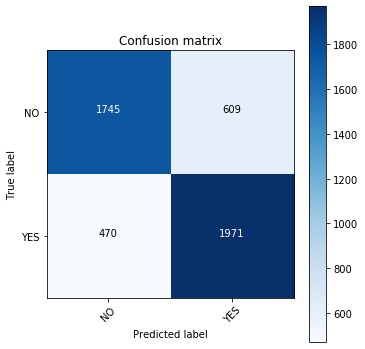

In [12]:
np.set_printoptions(precision=2)

# Ploting the non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, classes=['NO', 'YES'],
                      title='Confusion matrix')
plt.show()
